In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR3 as p
from linearmodels.asset_pricing import LinearFactorModel
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mea

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [42]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [43]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [44]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print(sect)

In [45]:
no_fx = [i for i in data.columns if i not in d_map['Currencies']]
PPCA=p.PPCA()
PPCA.fit(np.array(data[no_fx]),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(labels=sector_zscores[sect].index,axis=0)
    pcs[i]=x
sector_PC['All'] = pcs

In [46]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [47]:
priced_factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    priced_factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']
portfolios=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    portfolios[s+' Low']=sector_portfolio_sorts[s]['0']
    portfolios[s+' High']=sector_portfolio_sorts[s]['1']

In [48]:
total_common_factor=pd.DataFrame()
for s in sector_PC.keys():
    total_common_factor[s]=sector_PC[s].sum(axis=1)

In [49]:
factor.head()

,VAL,MOM,Total Common Factor,Sector Market Portfolio,Momentum,Value
DATE,,,,,,
1972-01-31,0.010065,-0.012955,NaN,NaN,-0.012955,0.010065
1972-02-29,-0.037528,0.038530,NaN,NaN,0.038530,-0.037528
1972-03-31,0.053548,-0.042824,NaN,NaN,-0.042824,0.053548
1972-04-30,0.007434,0.010658,NaN,NaN,0.010658,0.007434
1972-05-31,-0.019909,0.007096,NaN,NaN,0.007096,-0.019909


In [50]:
sec='All'
ind=total_common_factor[sec]['2000':'2016'].index
factor=pd.DataFrame()
factor=get_aqr_factors(sec).dropna()
factor['Total Common Factor']=total_common_factor[sec]/1000.
factor['Sector Market Portfolio']=sector_rtns[sec].mean(axis=1)
factor['Momentum']=get_aqr_factors('All')['MOM']
factor['Value']=get_aqr_factors('All')['VAL']
mod=LinearFactorModel(portfolios.loc[ind],
                      factor.loc[ind][['Total Common Factor','Sector Market Portfolio','Momentum','Value']])
res=mod.fit(cov_type='kernel')
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 14   R-squared:                      0.4321
No. Factors:                          4   J-statistic:                    46.164
No. Observations:                   192   P-value                         0.0000
Date:                  Mon, Jul 09 2018   Distribution:                 chi2(10)
Time:                          16:41:40                                         
Cov. Estimator:                  kernel                                         
                                                                                
                                   Risk Premia Estimates                                   
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Total Common Factor         0.0015     0.0053     0.2792     0.7801     -0.0

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [51]:
results=pd.DataFrame()
results['Liquidity Factor']=res.risk_premia*100
results['Tstats']=res.risk_premia_tstats
print(results.round(2).to_latex())

In [52]:
print(results.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Liquidity Factor &  Tstats \\
\midrule
Total Common Factor     &              0.15 &    0.28 \\
Sector Market Portfolio &              0.51 &    2.10 \\
Momentum                &              0.25 &    0.22 \\
Value                   &              0.22 &    0.25 \\
\bottomrule
\end{tabular}



In [55]:
a=res.params
b=res.tstats

In [59]:
print(b.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  alpha &  Total Common Factor &  Sector Market Portfolio &  Momentum &  Value \\
\midrule
Equities Low       &   0.10 &                 1.51 &                    11.63 &     -4.69 &  -0.59 \\
Equities High      &  -0.14 &                 2.18 &                    11.56 &     -3.18 &   1.33 \\
Agriculturals Low  &  -0.34 &                -1.80 &                    14.21 &      2.44 &   0.76 \\
Agriculturals High &   1.56 &                -3.12 &                    15.13 &      2.24 &   1.12 \\
Currencies Low     &  -2.19 &                -1.90 &                     6.77 &      1.06 &   1.09 \\
Currencies High    &  -0.90 &                -1.43 &                     6.11 &     -0.23 &   0.85 \\
Fixed Income Low   &   0.53 &                -1.71 &                     1.29 &      1.49 &  -1.54 \\
Fixed Income High  &   1.44 &                -1.01 &                    -4.27 &      0.56 &  -1.66 \\
Metals Low         &   0.12 &                -1.71 &    

# FHT

In [60]:
FHT=calculate_FHT(cleansed)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:286: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:287: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:287: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [61]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC_FHT[sect] = pcs
    except:
        print(sect)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [62]:
PPCA=p.PPCA()
PPCA.fit(np.array(data),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(labels=sector_zscores[sect].index,axis=0)
    pcs[i]=x
sector_PC['All'] = pcs

In [63]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [64]:
priced_factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    priced_factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']
portfolios=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    portfolios[s+' Low']=sector_portfolio_sorts[s]['0']
    portfolios[s+' High']=sector_portfolio_sorts[s]['1']

In [65]:
total_common_factor=pd.DataFrame()
for s in sector_PC.keys():
    total_common_factor[s]=sector_PC[s].sum(axis=1)

In [66]:
sec='All'
ind=total_common_factor[sec]['2000':'2016'].index
factor=pd.DataFrame()
factor=get_aqr_factors(sec).dropna()
factor['Total Common Factor']=total_common_factor[sec]/1000.
factor['Sector Market Portfolio']=sector_rtns[sec].mean(axis=1)

factor['Momentum']=get_aqr_factors('All')['MOM']
factor['Value']=get_aqr_factors('All')['VAL']
mod=LinearFactorModel(portfolios.loc[ind],
                      factor.loc[ind][['Total Common Factor','Sector Market Portfolio','Momentum','Value']])
#mod=LinearFactorModel(portfolios.loc[ind],
 #                     factor.loc[ind][['Total Common Factor','Sector Market Portfolio']])
res=mod.fit(cov_type='kernel')
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 14   R-squared:                      0.4209
No. Factors:                          4   J-statistic:                    36.502
No. Observations:                   204   P-value                         0.0001
Date:                  Mon, Jul 09 2018   Distribution:                 chi2(10)
Time:                          16:51:18                                         
Cov. Estimator:                  kernel                                         
                                                                                
                                   Risk Premia Estimates                                   
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Total Common Factor         0.0010     0.0021     0.4662     0.6411     -0.0

In [67]:
results['FHT Annual']=res.risk_premia*100
results['Tstats2']=res.risk_premia_tstats

In [68]:
results.round(2)

,Liquidity Factor,Tstats,FHT Annual,Tstats2
Total Common Factor,0.15,0.28,0.10,0.47
Sector Market Portfolio,0.51,2.10,0.50,2.16
Momentum,0.25,0.22,0.48,0.71
Value,0.22,0.25,-0.38,-0.81


In [69]:
print(res.tstats.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  alpha &  Total Common Factor &  Sector Market Portfolio &  Momentum &  Value \\
\midrule
Equities Low       &  -0.64 &                 2.58 &                    10.63 &     -3.25 &  -1.43 \\
Equities High      &   0.51 &                 2.21 &                     7.69 &     -4.22 &  -2.30 \\
Agriculturals Low  &   0.13 &                -0.80 &                    15.88 &      3.03 &   2.41 \\
Agriculturals High &   1.79 &                -3.27 &                    13.96 &      1.99 &   3.25 \\
Currencies Low     &  -2.42 &                 0.30 &                     5.16 &     -0.49 &  -0.75 \\
Currencies High    &  -1.28 &                -2.25 &                     7.72 &      0.05 &   1.19 \\
Fixed Income Low   &   0.68 &                -2.27 &                     0.37 &      0.96 &   0.22 \\
Fixed Income High  &   1.89 &                -1.36 &                    -0.74 &      1.32 &  -0.91 \\
Metals Low         &  -0.40 &                -1.96 &    

In [70]:
print(res.params.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  alpha &  Total Common Factor &  Sector Market Portfolio &  Momentum &  Value \\
\midrule
Equities Low       &   -0.0 &                 0.92 &                     1.07 &     -0.54 &  -0.31 \\
Equities High      &    0.0 &                 0.74 &                     0.86 &     -0.83 &  -0.59 \\
Agriculturals Low  &    0.0 &                -0.20 &                     1.32 &      0.36 &   0.33 \\
Agriculturals High &    0.0 &                -1.01 &                     1.39 &      0.25 &   0.49 \\
Currencies Low     &   -0.0 &                 0.06 &                     0.39 &     -0.04 &  -0.07 \\
Currencies High    &   -0.0 &                -0.45 &                     0.49 &      0.00 &   0.10 \\
Fixed Income Low   &    0.0 &                -0.13 &                     0.01 &      0.02 &   0.00 \\
Fixed Income High  &    0.0 &                -0.22 &                    -0.02 &      0.06 &  -0.05 \\
Metals Low         &   -0.0 &                -0.99 &    

In [72]:

results=pd.DataFrame()
results['Liquidity Factor']=res.risk_premia*100
results['Tstats']=res.risk_premia_tstats
print(results.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Liquidity Factor &  Tstats \\
\midrule
Total Common Factor     &              0.10 &    0.47 \\
Sector Market Portfolio &              0.50 &    2.16 \\
Momentum                &              0.48 &    0.71 \\
Value                   &             -0.38 &   -0.81 \\
\bottomrule
\end{tabular}



In [22]:
from linearmodels.asset_pricing import LinearFactorModelGMM
mod=LinearFactorModelGMM(sector_rtns[sec].loc[ind],sector_PC[sec][0])

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [23]:
res = mod.fit(cov_type='kernel', kernel='bartlett', disp=0)
print(res)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                  -1.378e+07
No. Factors:                          1   J-statistic:                 -1.66e+20
No. Observations:                    53   P-value                         1.0000
Date:                  Thu, May 31 2018   Distribution:                 chi2(27)
Time:                          06:34:51                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor        -137.01     41.197    -3.3257     0.0009     -217.75     -56.264

Covariance estimator:
KernelCovaria

In [24]:
res = mod.fit(steps=10, disp=25)
print(res)

Iteration: 0, Objective: -2.0468072446818114e+27
         Current function value: -2046807244681811382006448128.000000
         Iterations: 1
         Function evaluations: 1739
         Gradient evaluations: 54
Iteration: 0, Objective: 25452034914419.758
Optimization terminated successfully.
         Current function value: -7955459326391378813980732607433088188757944827904.000000
         Iterations: 2
         Function evaluations: 416
         Gradient evaluations: 13
Iteration: 0, Objective: 6.812958485828795e+34
         Current function value: -3982923168325853428992010790895616.000000
         Iterations: 4
         Function evaluations: 3788
         Gradient evaluations: 118
Iteration: 0, Objective: 5.359043869257105e+34
         Current function value: 52664213649380644073926352594534400.000000
         Iterations: 3
         Function evaluations: 3372
         Gradient evaluations: 105
Iteration: 0, Objective: 4.00995480473324e+34
         Current function value: 3356313769

In [25]:
print(res.full_summary)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                  -2.458e+20
No. Factors:                          1   J-statistic:                 6.476e+34
No. Observations:                    53   P-value                         0.0000
Date:                  Thu, May 31 2018   Distribution:                 chi2(27)
Time:                          06:34:59                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor     -2.821e+08     0.0495 -5.699e+09     0.0000  -2.821e+08  -2.821e+08


                          AEX-AEX 

# FHT method

In [143]:
FHT=calculate_FHT(cleansed)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:53: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:54: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [146]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC_FHT[sect] = pcs
    except:
        print(sect)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


# Presentation
First rsquares of residuals

In [127]:
FF=pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [130]:
FF.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')

In [147]:
temp=pd.DataFrame()
temp=sector_PC_FHT[sec][[0]]
temp['Mkt-RF']=FF['Mkt-RF']

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
sec='Fixed Income'
ind=sector_PC[sec][0].index
mod=LinearFactorModel(sector_rtns[sec].loc[ind],temp)
res=mod.fit(cov_type='kernel')
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 26   R-squared:                      0.1178
No. Factors:                          2   J-statistic:                    235.81
No. Observations:                    46   P-value                         0.0000
Date:                  Sun, Mar 18 2018   Distribution:                 chi2(24)
Time:                          16:11:04                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
0              0.2476     1.0627     0.2330     0.8157     -1.8352      2.3305
Mkt-RF         0.0021     0.0107    

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


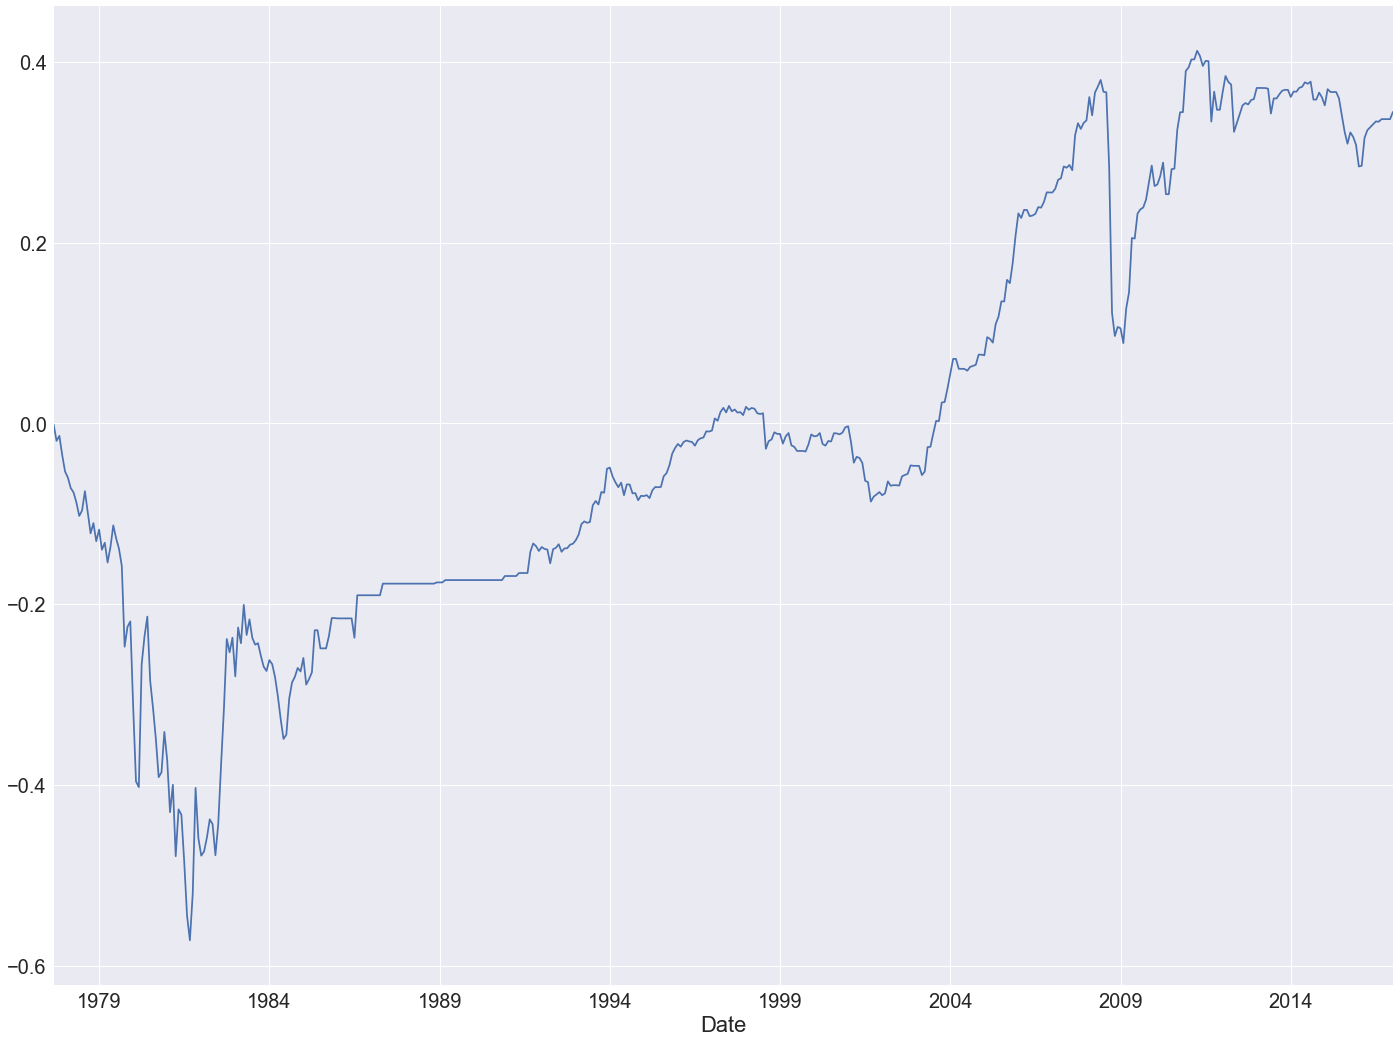

In [159]:
cleansed.resample(rule='m',how='last').pct_change().median(axis=1).cumsum().dropna().plot()

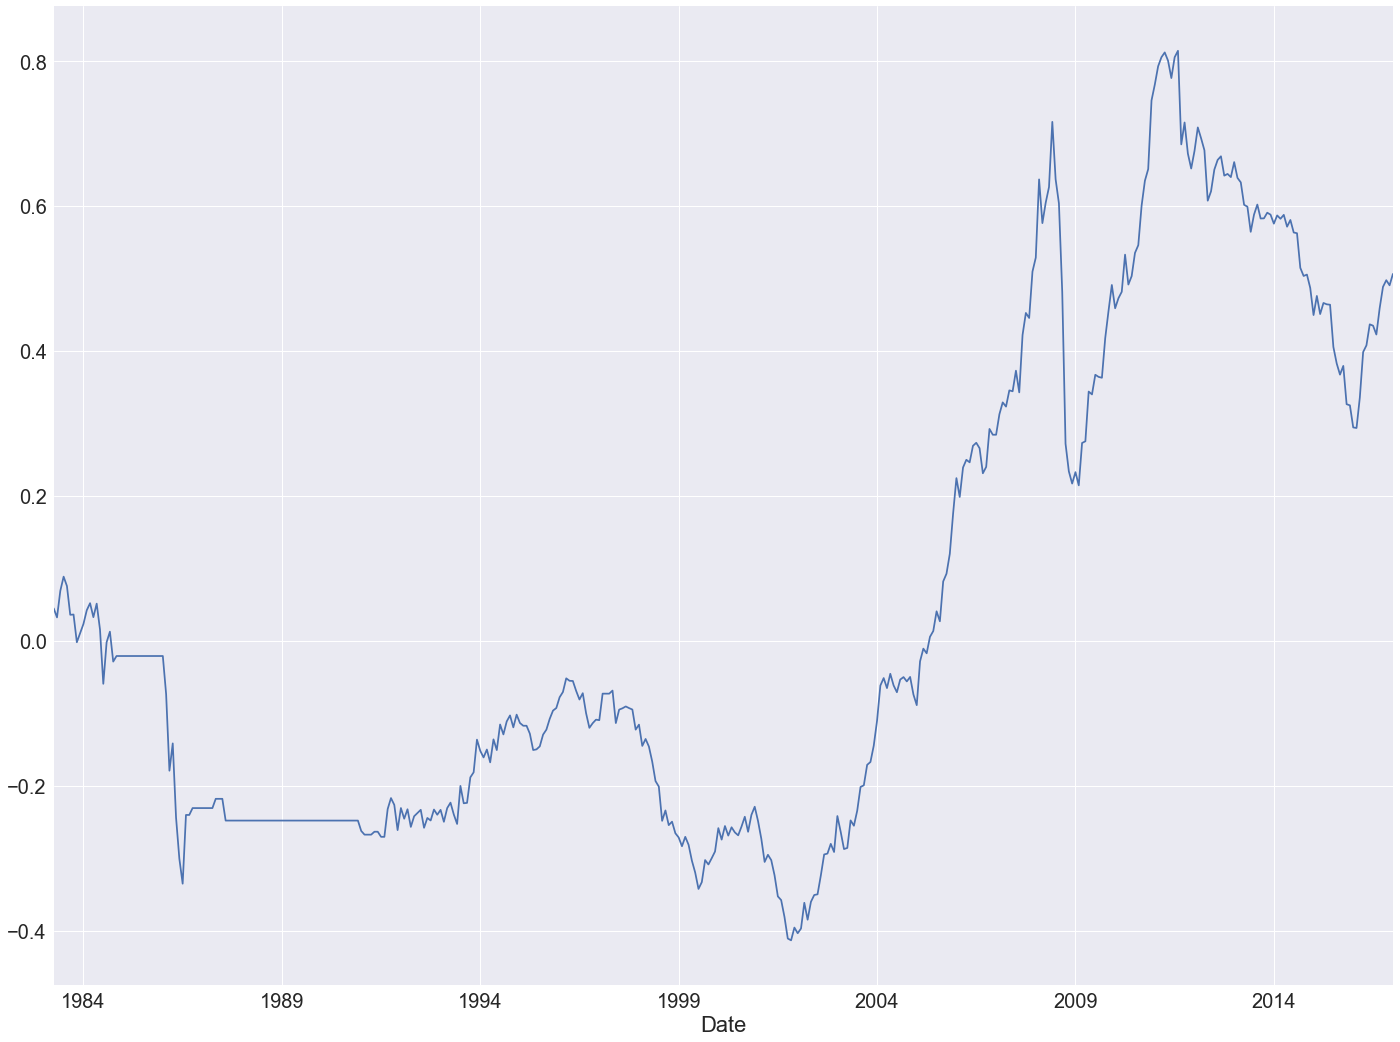

In [163]:
sector_rtns['Commodities'].median(axis=1).cumsum().plot()